In [1]:
## PROCEDURE:

# 1. Take three screen recordings of different angles of the paper (x, y, and z) being folded from 0% to 100%.
#     - Origami simulator: https://origamisimulator.org/. 
# 2. Import videos and use motion tracker on corners - try different tracker resistant to disappearance of object. 
#     - Run tracker 12 (3x4) times as tracking corners separately (wings tips, beak, and tail). 
# 3. Create 4 different xy-matrices (for each axis) - should have 6 rows each.
#     - We want to compare motion according to the corner!
#     - Otherwise, PCA shall be comparing different corners along the same axis.
# 4. Run PCA and SINDy - each corner SINDy should have either 2 or 4 elements (consider physics behind that). 
# 5. Run a comparison between SINDY models and see how similar the motion is for each corner.
#     - PCA and SINDy models: Compare the two motion models for the wing tips and the two motion models for the beak and tail in order to see how well they overlap. 
#     - Overlap the PCA and SINDy model graphs and perhaps run an error calculation or simply visualize the difference between the models.
# 6. Future directions: motion tracker for four corners at the same time.
#     - A single motion tracker would lead to a very complex SINDy model.
#     - Disappearance of the corners means the tracker may get confused. 

#   o Basically, an x, y, and z point of view, making sure to get the crane's head at the front corner for the x and y angles. 
#   o The colour is 66CC00 for both sides of the paper, as it kind of lags with two separate colours. 
#   o We are using the crane as it is the oldest model of origami. 
#   o The corners end up at the tips of the model due to the symmetry of the model.
#     - The center of the paper ends up at the middle point of the back once complete. 

In [7]:
! pip install numpy
import numpy as np
import scipy.io
import matplotlib.pyplot as lib
from PIL import Image as im
import cv2 as cv

In [3]:
## IMPORTING VIDEOS AS ARRAYS:

cranex = cv.VideoCapture("CraneX.mp4") 

# Defining the columns of the empty matrix:

framecount = int(cranex.get(cv.CAP_PROP_FRAME_COUNT))
width = int(cranex.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cranex.get(cv.CAP_PROP_FRAME_HEIGHT))

# Creating a buffer in order to be able to insert the information from the video into it:

bufferx = np.empty((framecount, height, width, 3), np.dtype('uint8')) 
# 8-bit unsigned integer, desired output (due to the RGB values).
# The buffer stores information temporarily.

fc = 0
ret = True

while (fc < framecount and ret):
    ret, bufferx[fc] = cranex.read()
    fc += 1

cranex.release()

print(bufferx.shape) # (238 [frames], 1280 [width], 1280 [height], 3 [RGB])
print(bufferx)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

craney = cv.VideoCapture("CraneY.mp4") 

# Defining the columns of the empty matrix:

framecount = int(craney.get(cv.CAP_PROP_FRAME_COUNT))
width = int(craney.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(craney.get(cv.CAP_PROP_FRAME_HEIGHT))

# Creating a buffer in order to be able to insert the information from the video into it:

buffery = np.empty((framecount, height, width, 3), np.dtype('uint8')) 
# 8-bit unsigned integer, desired output (due to the RGB values).
# The buffer stores information temporarily.

fc = 0
ret = True

while (fc < framecount and ret):
    ret, buffery[fc] = craney.read()
    fc += 1

craney.release()

print(buffery.shape) # (227 [frames], 1280 [width], 1280 [height], 3 [RGB])
print(buffery)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

cranez = cv.VideoCapture("CraneZ.mp4") 

# Defining the columns of the empty matrix:

framecount = int(cranez.get(cv.CAP_PROP_FRAME_COUNT))
width = int(cranez.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cranez.get(cv.CAP_PROP_FRAME_HEIGHT))

# Creating a buffer in order to be able to insert the information from the video into it:

bufferz = np.empty((framecount, height, width, 3), np.dtype('uint8')) 
# 8-bit unsigned integer, desired output (due to the RGB values).
# The buffer stores information temporarily.

fc = 0
ret = True

while (fc < framecount and ret):
    ret, bufferz[fc] = cranez.read()
    fc += 1

cranez.release()

print(bufferz.shape) # (225 [frames], 1280 [width], 1280 [height], 3 [RGB]).
print(bufferz)

(238, 1280, 1280, 3)
[[[[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  ...

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]]


 [[[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255

In [4]:
## DECLARING THE TRACKERS:
# Reference: https://broutonlab.com/blog/opencv-object-tracking.

tracker_types = ["BOOSTING", "MIL", "KCF", "TLD", "MEDIANFLOW", "MOSSE", "CSRT"]
tracker_type = tracker_types[1]

if tracker_type == "BOOSTING":
    tracker = cv.legacy.TrackerBoosting_create()
if tracker_type == "MIL":
    tracker = cv.TrackerMIL_create() 
if tracker_type == "KCF":
    tracker = cv.TrackerKCF_create() 
if tracker_type == "TLD":
    tracker = cv.legacy.TrackerTLD_create() 
if tracker_type == "MEDIANFLOW":
    tracker = cv.legacy.TrackerMedianFlow_create() 
if tracker_type == "MOSSE":
    tracker = cv.legacy.TrackerMOSSE_create()
if tracker_type == "CSRT":
    tracker = cv.TrackerCSRT_create()

# Instead of guessing where the tracked object is in the next frame, an approach is used in which several potentially positive objects are selected around a positive definite object. 
#    o Pros: more robust to noise, shows fairly good accuracy.
#     - There is a point in the video where everything melds together, this tracker is robust enough to handle it.
#    o Cons: relatively low speed and the impossibility of stopping tracking when the object is lost.
#     - The tracker being slow is a good thing! Our video is too fast in some places for the other trackers to follow.

In [49]:
## SAVING THE COORDINATES OF THE TRACKING RECTANGLE:
# Creating a matrix of zeros to then enter the coordinates of the box.

mat_beak = np.zeros((0,225))
mat_rw = np.zeros((0,225))
mat_lw = np.zeros((0,225))
mat_tail = np.zeros((0,225))
# The minimal number of frames is 225 from the z-axis crane. Thus, the matrices must account for this; the tracker shall only generate 224 data points.

In [6]:
## OBJECT TRACKING WITH OPENCV: X-BEAK
# This code allows us to select a box around the object:

# Get the video file and read it:
CX_beak = cv.VideoCapture("CraneX.mp4")
ret, frame = CX_beak.read()

# Select the bounding box in the first frame:
bbox = cv.selectROI(frame, False)
ret = tracker.init(frame, bbox)

In [7]:
## STORING THE COORDINATES: X-BEAK

X1_beak = np.zeros((238,1))
Y1_beak = np.zeros((238,1))

i = 0

while True:
    ret,frame = CX_beak.read()
    if not ret:
        break
    (success,box) = tracker.update(frame)
    if success:
        (x,y,w,h) = [int(a) for a in box]
        cv.rectangle(frame, (x,y), (x+w,y+h), (250,0,250), 2) # Image, start point, end point, colour (RGB), thickness.
        XC1_beak = (x+w)/2
        YC1_beak = (y+h)/2
        print(XC1_beak, YC1_beak)
        X1_beak[i] = XC1_beak
        Y1_beak[i] = YC1_beak
    cv.imshow("Frame", frame) # We need a positional argument, matrix form.
    key = cv.waitKey(30)
    i += 1
    if key == ord("q"):
        break

CX_beak.release()
cv.destroyAllWindows()

83.5 557.0
84.0 556.5
83.5 557.0
82.5 557.0
83.5 557.0
83.5 557.0
83.5 556.5
83.5 557.0
84.0 556.0
82.5 558.0
83.5 557.0
83.5 557.0
83.0 558.0
84.0 556.5
83.5 557.0
83.5 557.0
82.5 558.0
84.0 556.0
83.5 557.0
83.0 558.0
84.0 556.0
83.5 556.5
83.5 556.5
83.0 558.0
84.0 556.5
84.5 556.0
82.5 558.0
83.0 558.0
82.5 558.0
83.5 557.0
82.5 558.0
82.5 558.5
83.0 558.0
83.0 558.0
82.5 559.0
83.0 559.0
83.0 559.0
83.0 559.0
83.0 558.0
83.5 559.0
83.0 559.0
83.0 559.0
82.5 560.0
83.5 560.0
83.0 560.0
81.0 564.0
83.0 559.0
84.0 561.0
84.5 561.0
85.0 560.0
85.0 559.5
85.0 559.5
85.5 560.0
85.5 560.5
85.5 561.0
85.0 561.0
85.0 560.5
85.0 561.0
85.0 561.0
86.0 560.5
85.5 560.5
85.5 561.5
85.5 560.5
86.0 560.0
86.0 560.5
86.0 560.0
86.5 559.5
86.0 560.0
86.5 560.0
86.5 559.5
87.0 558.5
86.0 559.5
86.5 559.0
86.5 559.0
86.5 559.0
86.5 558.5
87.0 558.0
87.0 558.0
87.0 558.0
87.5 557.5
87.5 557.5
88.5 557.0
88.0 557.0
89.0 556.0
89.0 556.0
89.0 556.0
89.5 555.5
89.5 555.0
90.0 555.0
90.0 555.0
90.5 554.0

In [9]:
## OBJECT TRACKING WITH OPENCV: X-RIGHT WING
# This code allows us to select a box around the object:

# Get the video file and read it:
CX_rw = cv.VideoCapture("CraneX.mp4")
ret, frame = CX_rw.read()

# Select the bounding box in the first frame:
bbox = cv.selectROI(frame, False)
ret = tracker.init(frame, bbox)


In [10]:
## STORING THE COORDINATES: X-RIGHT WING

X1_rw = np.zeros((238,1))
Y1_rw = np.zeros((238,1))

i = 0

while True:
    ret,frame = CX_rw.read()
    if not ret:
        break
    (success,box) = tracker.update(frame)
    if success:
        (x,y,w,h) = [int(a) for a in box]
        cv.rectangle(frame, (x,y), (x+w,y+h), (250,0,250), 2) # Image, start point, end point, colour (RGB), thickness.
        XC1_rw = (x+w)/2
        YC1_rw = (y+h)/2
        print(XC1_rw, YC1_rw)
        X1_rw[i] = XC1_rw
        Y1_rw[i] = YC1_rw
    cv.imshow("Frame", frame) # We need a positional argument, matrix form.
    key = cv.waitKey(30)
    i += 1
    if key == ord("q"):
        break

CX_rw.release()
cv.destroyAllWindows()

122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 315.5
122.5 316.0
122.5 315.5
122.5 316.0
122.5 315.5
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
122.5 316.0
123.0 316.5
123.0 316.5
123.0 317.0
123.5 317.0
123.5 316.5
123.5 317.5
124.0 318.0
125.5 318.0
124.5 319.0
124.5 320.0
125.0 320.0
125.5 320.0
126.0 320.5
126.0 321.5
126.5 322.0
127.0 322.0
127.0 324.0
127.5 323.5
127.5 324.0
129.5 324.0
129.5 325.0
130.0 326.0
130.0 325.5
131.0 325.5
131.0 326.5
131.0 327.0
131.5 327.0
132.0 327.5
131.5 328.0
132.5 329.0
133.0 329.0
133.5 329.5
133.5 330.0
134.0 330.0
134.0 330.0
134.5 331.0
135.0 331.0
135.5 331.5
135.5 331.5
136.0 332.0
136.5 332.5
137.5 333.0
138.5 333.0
139.0 333.5
139.

In [11]:
## OBJECT TRACKING WITH OPENCV: X-LEFT WING
# This code allows us to select a box around the object:

# Get the video file and read it:
CX_lw = cv.VideoCapture("CraneX.mp4")
ret, frame = CX_lw.read()

# Select the bounding box in the first frame:
bbox = cv.selectROI(frame, False)
ret = tracker.init(frame, bbox)

In [12]:
## STORING THE COORDINATES: X-LEFT WING

X1_lw = np.zeros((238,1))
Y1_lw = np.zeros((238,1))

i = 0

while True:
    ret,frame = CX_lw.read()
    if not ret:
        break
    (success,box) = tracker.update(frame)
    if success:
        (x,y,w,h) = [int(a) for a in box]
        cv.rectangle(frame, (x,y), (x+w,y+h), (250,0,250), 2) # Image, start point, end point, colour (RGB), thickness.
        XC1_lw = (x+w)/2
        YC1_lw = (y+h)/2
        print(XC1_lw, YC1_lw)
        X1_lw[i] = XC1_lw
        Y1_lw[i] = YC1_lw
    cv.imshow("Frame", frame) # We need a positional argument, matrix form.
    key = cv.waitKey(30)
    i += 1
    if key == ord("q"):
        break

CX_lw.release()
cv.destroyAllWindows()

600.5 429.5
600.0 430.0
599.5 430.0
599.5 430.0
599.5 430.0
599.0 429.5
599.0 429.5
598.5 429.5
599.0 429.5
599.5 429.5
598.5 429.5
599.0 429.5
599.0 429.5
599.0 429.5
598.5 429.5
599.0 429.5
599.0 429.5
599.0 429.5
599.0 429.5
599.0 429.5
599.0 429.5
599.0 429.5
599.0 429.5
599.0 429.0
599.0 429.5
598.0 429.5
599.0 429.0
599.0 429.5
599.0 429.5
599.0 429.5
599.0 429.0
599.0 429.0
599.0 429.5
599.0 429.0
598.5 429.0
599.0 429.0
599.0 428.5
599.0 428.5
599.0 429.0
599.5 429.5
599.0 429.0
599.0 429.5
599.0 429.5
599.0 429.5
599.5 430.0
599.5 430.5
599.5 431.0
599.5 431.5
599.5 431.5
599.5 432.0
600.0 432.5
600.5 433.0
600.0 433.0
600.0 433.5
600.5 434.5
600.5 435.0
600.5 434.5
600.5 435.0
600.5 435.5
600.5 435.0
600.5 436.0
600.5 436.0
600.5 436.5
600.5 437.0
600.5 437.0
600.5 437.0
600.5 437.5
601.0 438.0
600.0 438.5
600.5 438.0
600.0 439.0
600.0 439.0
600.0 439.0
600.5 439.5
600.0 439.5
600.5 439.5
600.0 440.0
600.5 440.0
600.0 440.5
600.0 440.5
599.0 440.0
599.0 440.0
598.0 440.5
598.

In [13]:
## OBJECT TRACKING WITH OPENCV: X-TAIL
# This code allows us to select a box around the object:

# Get the video file and read it:
CX_tail = cv.VideoCapture("CraneX.mp4")
ret, frame = CX_tail.read()

# Select the bounding box in the first frame:
bbox = cv.selectROI(frame, False)
ret = tracker.init(frame, bbox)

In [14]:
## STORING THE COORDINATES: X-TAIL

X1_tail = np.zeros((238,1))
Y1_tail = np.zeros((238,1))

i = 0

while True:
    ret,frame = CX_tail.read()
    if not ret:
        break
    (success,box) = tracker.update(frame)
    if success:
        (x,y,w,h) = [int(a) for a in box]
        cv.rectangle(frame, (x,y), (x+w,y+h), (250,0,250), 2) # Image, start point, end point, colour (RGB), thickness.
        XC1_tail = (x+w)/2
        YC1_tail = (y+h)/2
        print(XC1_tail, YC1_tail)
        X1_tail[i] = XC1_tail
        Y1_tail[i] = YC1_tail
    cv.imshow("Frame", frame) # We need a positional argument, matrix form.
    key = cv.waitKey(30)
    i += 1
    if key == ord("q"):
        break

CX_tail.release()
cv.destroyAllWindows()

575.5 173.5
576.0 173.5
576.0 173.0
573.0 174.5
576.0 173.5
574.5 173.5
576.0 173.5
574.5 174.0
576.0 173.5
575.0 173.5
576.0 173.5
575.5 174.0
576.0 173.5
573.0 174.5
573.0 174.0
576.0 173.5
575.5 174.0
575.5 173.5
576.0 173.5
576.0 173.5
576.0 173.5
575.5 173.5
576.0 173.5
576.0 173.5
576.0 173.5
575.5 173.5
576.0 173.5
576.0 173.5
576.0 173.5
576.0 173.5
576.0 173.5
576.0 173.5
576.0 173.5
576.0 173.5
576.0 173.5
576.0 173.0
576.0 173.0
576.0 173.0
576.0 173.0
576.0 173.0
576.0 173.0
576.0 173.0
576.0 173.0
576.0 173.0
576.0 173.0
576.0 173.0
576.0 173.5
576.0 173.5
576.0 173.5
576.0 173.5
576.0 173.5
576.0 173.5
576.0 173.5
576.0 173.5
576.0 173.5
576.0 173.5
576.0 173.5
576.0 173.5
576.0 173.5
575.5 173.0
575.5 173.0
575.5 172.5
575.5 172.5
575.5 172.5
575.5 172.0
575.0 172.0
575.0 172.0
575.0 171.5
575.0 171.5
575.0 171.0
575.0 170.5
574.5 170.5
574.5 170.5
574.5 170.0
574.5 169.5
574.0 169.5
574.0 169.0
574.0 168.5
574.0 168.5
573.5 168.0
573.0 168.0
573.0 167.5
573.0 167.0
572.

In [15]:
## OBJECT TRACKING WITH OPENCV: Y-BEAK
# This code allows us to select a box around the object:

# Get the video file and read it:
CY_beak = cv.VideoCapture("CraneY.mp4")
ret, frame = CY_beak.read()

# Select the bounding box in the first frame:
bbox = cv.selectROI(frame, False)
ret = tracker.init(frame, bbox)

In [16]:
## STORING THE COORDINATES: Y-BEAK

X2_beak = np.zeros((227,1))
Y2_beak = np.zeros((227,1))

i = 0

while True:
    ret,frame = CY_beak.read()
    if not ret:
        break
    (success,box) = tracker.update(frame)
    if success:
        (x,y,w,h) = [int(a) for a in box]
        cv.rectangle(frame, (x,y), (x+w,y+h), (250,0,250), 2) # Image, start point, end point, colour (RGB), thickness.
        XC2_beak = (x+w)/2
        YC2_beak = (y+h)/2
        print(XC2_beak, YC2_beak)
        X2_beak[i] = XC2_beak
        Y2_beak[i] = YC2_beak
    cv.imshow("Frame", frame) # We need a positional argument, matrix form.
    key = cv.waitKey(30)
    i += 1
    if key == ord("q"):
        break

CY_beak.release()
cv.destroyAllWindows()

574.0 504.5
574.0 504.5
574.0 504.5
574.0 504.0
574.0 504.5
574.5 504.5
574.0 504.5
574.0 504.5
574.0 504.5
574.0 504.5
573.5 504.0
573.5 504.5
574.0 504.5
573.5 504.5
574.0 504.0
574.0 504.0
574.0 504.0
574.0 504.5
574.0 504.5
574.0 504.5
573.5 504.5
573.5 504.5
574.0 505.0
573.5 505.0
573.5 505.0
574.0 505.0
573.5 505.5
573.5 505.0
573.0 505.0
573.5 505.5
573.5 505.5
574.0 505.5
573.5 505.5
574.0 505.5
573.5 506.0
573.0 506.0
573.0 506.0
572.5 506.5
574.0 506.5
574.0 506.5
574.0 507.0
573.5 507.0
573.5 507.5
573.5 507.0
574.0 507.5
574.0 507.5
573.0 507.5
573.5 507.5
574.0 508.0
573.5 508.0
574.0 507.0
574.0 507.5
574.0 507.5
573.0 507.5
573.5 507.5
573.5 507.5
573.0 507.5
573.5 507.5
573.0 508.0
573.5 508.5
572.5 508.0
572.5 507.5
572.5 507.5
572.5 507.0
572.5 507.0
571.5 506.5
571.5 506.5
572.0 506.0
570.5 506.5
572.5 506.0
570.5 506.0
570.0 505.5
571.0 505.5
569.5 505.0
571.5 505.0
569.0 505.0
569.0 504.5
568.5 504.5
568.5 504.0
568.0 503.5
568.0 504.0
568.5 504.0
568.0 503.5
567.

In [21]:
## OBJECT TRACKING WITH OPENCV: Y-RIGHT WING
# This code allows us to select a box around the object:

# Get the video file and read it:
CY_rw = cv.VideoCapture("CraneY.mp4")
ret, frame = CY_rw.read()

# Select the bounding box in the first frame:
bbox = cv.selectROI(frame, False)
ret = tracker.init(frame, bbox)

In [22]:
##STORING THE COORDINATES: Y-RIGHT WING

X2_rw = np.zeros((227,1))
Y2_rw = np.zeros((227,1))

i = 0

while True:
    ret,frame = CY_rw.read()
    if not ret:
        break
    (success,box) = tracker.update(frame)
    if success:
        (x,y,w,h) = [int(a) for a in box]
        cv.rectangle(frame, (x,y), (x+w,y+h), (250,0,250), 2) # Image, start point, end point, colour (RGB), thickness.
        XC2_rw = (x+w)/2
        YC2_rw = (y+h)/2
        print(XC2_rw, YC2_rw)
        X2_rw[i] = XC2_rw
        Y2_rw[i] = YC2_rw
    cv.imshow("Frame", frame) # We need a positional argument, matrix form.
    key = cv.waitKey(30)
    i += 1
    if key == ord("q"):
        break

CY_rw.release()
cv.destroyAllWindows()

148.5 542.0
148.0 542.0
149.0 541.5
148.0 542.0
148.0 542.0
148.0 542.0
148.0 542.0
148.0 542.0
148.0 542.0
148.0 542.0
148.0 542.0
148.0 542.0
148.5 541.5
148.5 541.5
148.5 541.5
148.0 542.0
148.0 541.5
148.0 542.0
148.0 541.5
148.0 542.0
148.0 541.5
147.5 542.0
148.0 542.0
148.0 541.5
148.0 542.0
147.5 542.0
147.5 542.0
148.0 542.0
147.5 542.5
147.0 543.0
147.5 543.0
147.5 543.5
148.0 543.5
148.0 544.0
148.0 544.0
148.5 544.5
148.5 545.5
148.5 545.5
149.5 545.5
149.5 546.0
150.0 547.0
150.0 547.5
150.5 547.5
150.5 548.5
151.0 548.5
151.5 549.0
151.5 549.5
152.0 550.0
153.0 550.0
152.5 551.0
154.0 551.0
154.0 551.0
154.0 552.0
154.5 552.5
155.0 552.5
155.0 553.0
156.0 553.0
156.5 553.5
156.5 553.5
158.0 553.5
157.0 553.5
158.0 554.0
158.5 554.5
158.5 556.5
160.0 555.0
160.5 555.0
162.0 555.5
162.0 555.5
164.0 555.5
165.0 555.0
164.0 558.0
164.0 558.0
164.0 557.5
167.0 557.5
167.0 557.5
168.5 558.0
169.0 558.0
171.0 558.5
171.0 559.5
171.5 560.0
172.0 560.5
172.5 561.0
174.0 562.0
175.

In [23]:
## OBJECT TRACKING WITH OPENCV: Y-LEFT WING
# This code allows us to select a box around the object:

# Get the video file and read it:
CY_lw = cv.VideoCapture("CraneY.mp4")
ret, frame = CY_lw.read()

# Select the bounding box in the first frame:
bbox = cv.selectROI(frame, False)
ret = tracker.init(frame, bbox)

In [24]:
##STORING THE COORDINATES: Y-LEFT WING

X2_lw = np.zeros((227,1))
Y2_lw = np.zeros((227,1))

i = 0

while True:
    ret,frame = CY_lw.read()
    if not ret:
        break
    (success,box) = tracker.update(frame)
    if success:
        (x,y,w,h) = [int(a) for a in box]
        cv.rectangle(frame, (x,y), (x+w,y+h), (250,0,250), 2) # Image, start point, end point, colour (RGB), thickness.
        XC2_lw = (x+w)/2
        YC2_lw = (y+h)/2
        print(XC2_lw, YC2_lw)
        X2_lw[i] = XC2_lw
        Y2_lw[i] = YC2_lw
    cv.imshow("Frame", frame) # We need a positional argument, matrix form.
    key = cv.waitKey(30)
    i += 1
    if key == ord("q"):
        break

CY_lw.release()
cv.destroyAllWindows()

626.5 244.0
626.5 244.0
626.5 244.0
626.5 244.0
626.5 244.0
626.5 244.0
626.5 243.5
626.5 243.5
626.5 244.0
626.5 244.0
626.5 244.0
626.5 244.0
626.5 243.5
626.5 243.5
626.5 244.0
626.5 244.0
626.5 244.0
626.5 244.5
626.5 244.0
626.5 244.0
626.0 244.5
626.5 244.0
627.5 244.5
627.5 244.5
626.5 244.0
627.0 243.5
627.5 244.5
627.5 244.5
627.0 245.0
627.5 245.0
627.5 245.0
627.0 245.5
627.5 245.5
627.0 246.0
627.0 246.0
627.0 246.5
627.5 246.0
627.0 247.0
627.5 247.5
626.5 247.5
626.0 248.0
626.0 248.5
626.0 249.0
626.5 250.0
626.5 250.0
626.5 250.5
626.5 251.5
625.0 252.0
625.5 253.0
625.0 254.0
625.0 254.5
624.5 254.0
624.5 254.5
624.5 256.0
623.5 256.0
623.0 257.5
623.0 257.5
623.0 257.5
622.5 258.0
621.5 259.5
622.0 259.5
622.5 260.0
621.0 261.0
620.5 262.0
620.0 262.0
619.0 263.0
618.0 264.0
617.0 265.0
617.0 265.0
616.0 265.5
616.0 266.0
615.0 268.0
614.5 268.0
614.0 268.0
613.5 269.0
612.5 269.5
611.5 271.0
611.5 271.0
610.5 272.0
610.5 272.5
609.5 273.5
609.0 275.0
608.5 275.0
607.

In [25]:
## OBJECT TRACKING WITH OPENCV: Y-TAIL
# This code allows us to select a box around the object:

# Get the video file and read it:
CY_tail = cv.VideoCapture("CraneY.mp4")
ret, frame = CY_tail.read()

# Select the bounding box in the first frame:
bbox = cv.selectROI(frame, False)
ret = tracker.init(frame, bbox)

In [26]:
##STORING THE COORDINATES: Y-TAIL

X2_tail = np.zeros((227,1))
Y2_tail = np.zeros((227,1))

i = 0

while True:
    ret,frame = CY_tail.read()
    if not ret:
        break
    (success,box) = tracker.update(frame)
    if success:
        (x,y,w,h) = [int(a) for a in box]
        cv.rectangle(frame, (x,y), (x+w,y+h), (250,0,250), 2) # Image, start point, end point, colour (RGB), thickness.
        XC2_tail = (x+w)/2
        YC2_tail = (y+h)/2
        print(XC2_tail, YC2_tail)
        X2_tail[i] = XC2_tail
        Y2_tail[i] = YC2_tail
    cv.imshow("Frame", frame) # We need a positional argument, matrix form.
    key = cv.waitKey(30)
    i += 1
    if key == ord("q"):
        break

CY_tail.release()
cv.destroyAllWindows()

155.5 256.5
154.5 258.5
154.5 258.0
154.5 258.0
155.5 256.5
154.5 257.5
155.5 256.5
154.5 257.5
155.5 256.5
154.5 257.5
155.5 256.5
155.5 257.0
154.5 257.5
155.0 257.5
154.5 257.5
156.0 256.5
155.0 257.5
155.0 257.5
156.0 256.5
155.0 257.5
155.5 257.0
155.0 257.0
155.5 256.5
155.5 257.0
155.0 256.5
156.0 256.5
156.0 256.5
156.0 256.5
155.5 257.0
156.0 257.0
156.0 257.0
157.0 256.5
156.0 257.0
156.0 256.5
155.5 257.5
157.0 256.5
157.0 257.0
157.5 257.0
157.5 257.0
158.0 257.0
157.0 257.5
157.0 257.5
157.0 257.5
156.5 257.5
158.0 257.0
157.0 257.5
157.0 257.5
158.0 257.0
157.0 257.5
158.0 257.0
158.0 257.0
158.0 257.5
158.0 257.0
158.0 257.0
158.0 257.0
158.0 257.0
158.0 255.5
158.0 255.5
158.0 255.0
158.5 256.5
158.5 256.0
158.0 254.0
158.0 254.0
158.0 253.5
158.5 255.0
158.0 253.0
159.0 253.5
159.0 252.5
159.5 253.5
159.0 252.5
159.0 252.5
159.5 251.0
159.5 252.0
159.5 251.0
159.5 251.0
160.0 250.0
160.5 250.5
160.5 250.0
160.5 250.0
160.5 248.0
160.5 247.5
160.5 247.5
161.0 248.0
161.

In [27]:
##OBJECT TRACKING WITH OPENCV: Z-BEAK
# This code allows us to select a box around the object:

# Get the video file and read it:
CZ_beak = cv.VideoCapture("CraneZ.mp4")
ret, frame = CZ_beak.read()

# Select the bounding box in the first frame:
bbox = cv.selectROI(frame, False)
ret = tracker.init(frame, bbox)

In [28]:
##STORING THE COORDINATES: Z-BEAK

X3_beak = np.zeros((225,1))
Y3_beak = np.zeros((225,1))

i = 0

while True:
    ret,frame = CZ_beak.read()
    if not ret:
        break
    (success,box) = tracker.update(frame)
    if success:
        (x,y,w,h) = [int(a) for a in box]
        cv.rectangle(frame, (x,y), (x+w,y+h), (250,0,250), 2) # Image, start point, end point, colour (RGB), thickness.
        XC3_beak = (x+w)/2
        YC3_beak = (y+h)/2
        print(XC3_beak, YC3_beak)
        X3_beak[i] = XC3_beak
        Y3_beak[i] = YC3_beak
    cv.imshow("Frame", frame) # We need a positional argument, matrix form.
    key = cv.waitKey(30)
    i += 1
    if key == ord("q"):
        break

CZ_beak.release()
cv.destroyAllWindows()

85.5 639.5
86.0 639.0
85.5 639.0
85.5 639.0
85.5 639.0
85.5 639.0
85.5 639.0
85.5 639.0
85.5 639.0
85.5 639.0
85.5 638.5
85.5 639.0
85.5 638.5
85.5 639.0
85.5 639.0
85.5 639.0
85.5 638.5
85.5 639.0
85.5 639.0
85.5 639.0
85.5 638.5
85.5 638.5
85.5 638.5
85.5 639.0
85.5 639.0
85.5 639.0
85.5 639.0
85.5 638.5
85.5 639.0
85.5 638.5
85.5 638.5
84.5 639.5
85.0 639.0
85.0 638.5
85.5 638.5
84.5 638.5
86.5 639.0
84.5 638.5
84.5 638.5
84.5 638.5
85.5 638.0
85.0 638.0
84.5 638.5
84.5 638.0
84.5 637.0
84.5 637.0
84.5 637.0
84.5 636.5
84.5 636.5
84.0 636.5
83.0 637.0
83.0 637.0
83.5 636.5
83.5 636.0
83.5 636.0
83.5 636.0
83.5 636.0
83.0 635.5
84.0 635.5
83.5 635.0
83.5 635.0
83.5 635.0
84.0 635.0
84.0 635.0
84.0 635.5
83.5 636.0
84.0 635.0
83.0 634.5
83.0 635.5
84.0 635.5
83.5 635.5
83.5 635.5
84.0 635.5
83.5 636.0
85.0 635.5
84.0 636.0
84.5 635.5
84.5 635.5
84.5 635.5
85.5 635.5
85.5 635.5
85.5 635.5
85.5 635.5
86.5 636.0
86.0 635.5
86.5 635.5
86.5 636.0
87.0 635.5
87.5 635.5
87.0 635.5
88.0 635.5

In [31]:
##OBJECT TRACKING WITH OPENCV: Z-RIGHT WING
# This code allows us to select a box around the object:

# Get the video file and read it:
CZ_rw = cv.VideoCapture("CraneZ.mp4")
ret, frame = CZ_rw.read()

# Select the bounding box in the first frame:
bbox = cv.selectROI(frame, False)
ret = tracker.init(frame, bbox)

In [32]:
##STORING THE COORDINATES: Z-RIGHT WING

X3_rw = np.zeros((225,1))
Y3_rw = np.zeros((225,1))

i = 0

while True:
    ret,frame = CZ_rw.read()
    if not ret:
        break
    (success,box) = tracker.update(frame)
    if success:
        (x,y,w,h) = [int(a) for a in box]
        cv.rectangle(frame, (x,y), (x+w,y+h), (250,0,250), 2) # Image, start point, end point, colour (RGB), thickness.
        XC3_rw = (x+w)/2
        YC3_rw = (y+h)/2
        print(XC3_rw, YC3_rw)
        X3_rw[i] = XC3_rw
        Y3_rw[i] = YC3_rw
    cv.imshow("Frame", frame) # We need a positional argument, matrix form.
    key = cv.waitKey(30)
    i += 1
    if key == ord("q"):
        break

CZ_rw.release()
cv.destroyAllWindows()

214.5 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
213.5 226.0
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.5
214.0 225.0
214.0 225.0
214.0 225.0
214.0 225.5
211.5 224.0
212.0 225.0
213.0 225.0
212.5 224.5
212.5 224.5
212.5 224.5
212.5 225.0
211.5 224.5
211.5 224.0
210.5 223.5
212.5 224.5
212.0 224.0
212.0 224.0
212.0 224.0
212.0 223.5
212.0 224.0
212.0 224.0
211.5 223.0
211.5 223.0
211.5 222.5
211.0 222.5
210.5 222.0
210.5 222.0
208.0 229.0
210.0 221.5
209.5 221.5
209.5 222.0
209.5 221.5
209.5 222.0
209.5 221.5
209.0 222.0
209.0 222.0
211.0 219.0
209.5 221.5
209.0 221.0
209.0 221.0
209.5 221.0
209.5 221.0
209.5 221.0
210.0 221.0
209.5 221.0
210.0 221.0
210.0 221.0
210.0 221.0
210.5 219.0
210.0 220.0
210.0 220.0
210.0 220.5
210.0 220.5
210.0 221.0
210.0 221.0
210.0 221.0
210.

In [33]:
##OBJECT TRACKING WITH OPENCV: Z-LEFT WING
# This code allows us to select a box around the object:

# Get the video file and read it:
CZ_lw = cv.VideoCapture("CraneZ.mp4")
ret, frame = CZ_lw.read()

# Select the bounding box in the first frame:
bbox = cv.selectROI(frame, False)
ret = tracker.init(frame, bbox)

In [34]:
##STORING THE COORDINATES: Z-LEFT WING

X3_lw = np.zeros((225,1))
Y3_lw = np.zeros((225,1))

i = 0

while True:
    ret,frame = CZ_lw.read()
    if not ret:
        break
    (success,box) = tracker.update(frame)
    if success:
        (x,y,w,h) = [int(a) for a in box]
        cv.rectangle(frame, (x,y), (x+w,y+h), (250,0,250), 2) # Image, start point, end point, colour (RGB), thickness.
        XC3_lw = (x+w)/2
        YC3_lw = (y+h)/2
        print(XC3_lw, YC3_lw)
        X3_lw[i] = XC3_lw
        Y3_lw[i] = YC3_lw
    cv.imshow("Frame", frame) # We need a positional argument, matrix form.
    key = cv.waitKey(30)
    i += 1
    if key == ord("q"):
        break

CZ_lw.release()
cv.destroyAllWindows()

587.5 581.5
587.5 581.5
587.5 581.5
588.0 581.5
588.0 581.5
588.0 581.5
588.0 581.5
588.0 581.5
588.0 581.0
588.0 581.0
588.0 581.5
588.0 581.5
588.0 581.5
587.5 581.5
588.0 581.5
588.0 581.5
587.5 581.5
587.5 581.5
587.0 582.0
587.5 581.0
588.0 581.5
587.5 581.5
588.0 581.5
587.5 581.5
587.5 581.5
588.0 582.0
587.0 581.5
587.5 582.0
588.0 581.5
587.5 582.0
587.5 582.0
586.0 581.5
586.0 582.5
587.0 582.0
587.0 582.0
586.5 582.0
586.0 581.5
586.0 581.5
585.0 581.5
585.5 581.0
585.5 580.5
585.5 580.5
585.0 580.5
585.0 580.5
584.5 580.0
584.5 580.0
584.5 580.0
583.5 579.5
584.0 579.0
584.0 578.5
583.5 578.5
583.0 578.5
582.5 577.5
582.5 577.0
582.0 577.0
581.5 576.5
580.5 576.0
581.5 575.0
580.5 575.0
580.0 575.5
580.0 575.0
580.0 573.5
579.0 573.5
578.0 573.0
578.0 572.5
578.0 572.0
578.0 571.5
577.5 571.0
576.5 570.5
577.0 570.0
576.0 569.0
576.0 568.5
576.0 567.5
575.5 567.0
575.5 566.5
574.5 565.0
574.0 565.0
574.0 563.5
573.0 563.0
572.0 562.5
572.0 562.0
571.5 561.0
571.0 560.0
570.

In [35]:
##OBJECT TRACKING WITH OPENCV: Z-TAIL
# This code allows us to select a box around the object:

# Get the video file and read it:
CZ_tail = cv.VideoCapture("CraneZ.mp4")
ret, frame = CZ_tail.read()

# Select the bounding box in the first frame:
bbox = cv.selectROI(frame, False)
ret = tracker.init(frame, bbox)

In [36]:
##STORING THE COORDINATES: Z-TAIL

X3_tail = np.zeros((225,1))
Y3_tail = np.zeros((225,1))

i = 0

while True:
    ret,frame = CZ_tail.read()
    if not ret:
        break
    (success,box) = tracker.update(frame)
    if success:
        (x,y,w,h) = [int(a) for a in box]
        cv.rectangle(frame, (x,y), (x+w,y+h), (250,0,250), 2) # Image, start point, end point, colour (RGB), thickness.
        XC3_tail = (x+w)/2
        YC3_tail = (y+h)/2
        print(XC3_tail, YC3_tail)
        X3_tail[i] = XC3_tail
        Y3_tail[i] = YC3_tail
    cv.imshow("Frame", frame) # We need a positional argument, matrix form.
    key = cv.waitKey(30)
    i += 1
    if key == ord("q"):
        break

CZ_tail.release()
cv.destroyAllWindows()

629.5 94.5
629.5 94.0
629.5 94.5
629.5 94.5
629.5 94.5
629.5 94.5
629.5 94.5
629.5 94.5
629.5 94.5
629.5 94.5
629.0 94.5
629.0 94.5
629.5 94.5
629.0 94.5
629.0 94.5
628.5 94.5
629.0 94.0
628.5 94.5
629.0 94.0
629.0 94.0
628.5 94.0
629.0 94.0
629.0 94.5
628.5 94.5
628.5 94.5
628.5 94.5
628.5 94.0
629.0 94.5
628.5 94.5
628.5 94.0
629.0 94.5
629.0 94.5
629.5 94.0
629.5 94.0
629.0 94.0
629.0 94.0
629.0 94.0
629.0 94.0
628.5 94.5
628.5 94.0
628.5 94.0
628.5 94.0
628.5 94.0
628.5 94.0
628.5 93.5
628.5 93.5
629.0 92.0
629.0 92.0
628.5 93.0
629.0 92.5
629.0 93.0
628.5 93.0
629.0 92.0
628.5 92.0
628.5 92.5
628.5 92.5
628.5 92.5
628.5 92.0
628.5 92.0
628.5 92.0
629.0 91.5
628.5 92.5
628.5 92.5
628.5 92.5
628.0 92.5
628.5 93.0
628.5 93.0
628.5 93.0
628.5 94.0
628.5 94.0
628.5 94.5
628.5 94.5
629.0 94.5
629.0 95.0
629.5 95.5
628.5 95.0
628.5 96.5
629.0 96.5
629.5 97.5
629.5 97.5
629.5 97.5
629.5 98.0
629.5 98.5
629.5 99.0
629.5 99.5
629.5 100.0
629.5 100.0
629.5 101.0
630.5 101.0
630.5 100.5
630.5

In [50]:
print(mat_beak.shape)
print(mat_rw.shape)
print(mat_lw.shape)
print(mat_tail.shape)

(0, 225)
(0, 225)
(0, 225)
(0, 225)


In [51]:
X1_beak = np.resize(X1_beak, (225,1))
Y1_beak = np.resize(Y1_beak, (225,1)) 

X1_rw = np.resize(X1_rw, (225,1))
Y1_rw = np.resize(Y1_rw, (225,1)) 

X1_lw = np.resize(X1_lw, (225,1))
Y1_lw = np.resize(Y1_lw, (225,1)) 

X1_tail = np.resize(X1_tail, (225,1))
Y1_tail = np.resize(Y1_tail, (225,1)) 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

X2_beak = np.resize(X2_beak, (225,1)) 
Y2_beak = np.resize(Y2_beak, (225,1)) 

X2_rw = np.resize(X2_rw, (225,1)) 
Y2_rw = np.resize(Y2_rw, (225,1)) 

X2_lw = np.resize(X2_lw, (225,1)) 
Y2_lw = np.resize(Y2_lw, (225,1)) 

X2_tail = np.resize(X2_tail, (225,1)) 
Y2_tail = np.resize(Y2_tail, (225,1)) 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

X3_beak = np.resize(X3_beak, (225,1)) 
Y3beak = np.resize(Y3_beak, (225,1)) 

X3_rw = np.resize(X3_rw, (225,1)) 
Y3_rw = np.resize(Y3_rw, (225,1)) 

X3_lw = np.resize(X3_lw, (225,1)) 
Y3_lw = np.resize(Y3_lw, (225,1)) 

X3_tail = np.resize(X3_tail, (225,1)) 
Y3_tail = np.resize(Y3_tail, (225,1)) 

# Resizing due to the size of the xy-matrix.

In [52]:
X1_beak = np.reshape(X1_beak, (1,225))
Y1_beak = np.reshape(Y1_beak, (1,225)) 

X1_rw = np.reshape(X1_rw, (1,225))
Y1_rw = np.reshape(Y1_rw, (1,225)) 

X1_lw = np.reshape(X1_lw, (1,225))
Y1_lw = np.reshape(Y1_lw, (1,225)) 

X1_tail = np.reshape(X1_tail, (1,225))
Y1_tail = np.reshape(Y1_tail, (1,225)) 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

X2_beak = np.reshape(X2_beak, (1,225))
Y2_beak = np.reshape(Y2_beak, (1,225)) 

X2_rw = np.reshape(X2_rw, (1,225))
Y2_rw = np.reshape(Y2_rw, (1,225)) 

X2_lw = np.reshape(X2_lw, (1,225))
Y2_lw = np.reshape(Y2_lw, (1,225)) 

X2_tail = np.reshape(X2_tail, (1,225))
Y2_tail = np.reshape(Y2_tail, (1,225)) 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

X3_beak = np.reshape(X3_beak, (1,225))
Y3_beak = np.reshape(Y3_beak, (1,225)) 

X3_rw = np.reshape(X3_rw, (1,225))
Y3_rw = np.reshape(Y3_rw, (1,225)) 

X3_lw = np.reshape(X3_lw, (1,225))
Y3_lw = np.reshape(Y3_lw, (1,225)) 

X3_tail = np.reshape(X3_tail, (1,225))
Y3_tail = np.reshape(Y3_tail, (1,225)) 

# To match the matrix format (changing row vectors).

In [53]:
mat_beak = np.append(mat_beak, X1_beak, axis = 0)
mat_beak = np.append(mat_beak, Y1_beak, axis = 0)
mat_beak = np.append(mat_beak, X2_beak, axis = 0)
mat_beak = np.append(mat_beak, Y2_beak, axis = 0)
mat_beak = np.append(mat_beak, X3_beak, axis = 0)
mat_beak = np.append(mat_beak, Y3_beak, axis = 0)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

mat_rw = np.append(mat_rw, X1_rw, axis = 0)
mat_rw = np.append(mat_rw, Y1_rw, axis = 0)
mat_rw = np.append(mat_rw, X2_rw, axis = 0)
mat_rw = np.append(mat_rw, Y2_rw, axis = 0)
mat_rw = np.append(mat_rw, X3_rw, axis = 0)
mat_rw = np.append(mat_rw, Y3_rw, axis = 0)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

mat_lw = np.append(mat_lw, X1_lw, axis = 0)
mat_lw = np.append(mat_lw, Y1_lw, axis = 0)
mat_lw = np.append(mat_lw, X2_lw, axis = 0)
mat_lw = np.append(mat_lw, Y2_lw, axis = 0)
mat_lw = np.append(mat_lw, X3_lw, axis = 0)
mat_lw = np.append(mat_lw, Y3_lw, axis = 0)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

mat_tail = np.append(mat_tail, X1_tail, axis = 0)
mat_tail = np.append(mat_tail, Y1_tail, axis = 0)
mat_tail = np.append(mat_tail, X2_tail, axis = 0)
mat_tail = np.append(mat_tail, Y2_tail, axis = 0)
mat_tail = np.append(mat_tail, X3_tail, axis = 0)
mat_tail = np.append(mat_tail, Y3_tail, axis = 0)

In [55]:
print(mat_beak.shape)
print(mat_beak)

print(mat_rw.shape)
print(mat_rw)

print(mat_lw.shape)
print(mat_lw)

print(mat_tail.shape)
print(mat_tail)

(6, 225)
[[ 83.5  84.   83.5 ... 201.5 201.   83.5]
 [557.  556.5 557.  ... 438.5 438.  557. ]
 [574.  574.  574.  ... 436.5 436.5 574. ]
 [504.5 504.5 504.5 ... 391.  391.  504.5]
 [ 85.5  86.   85.5 ... 236.  235.5  85.5]
 [639.5 639.  639.  ... 512.  512.    0. ]]
(6, 225)
[[122.5 122.5 122.5 ... 194.  206.  122.5]
 [316.  316.  316.  ... 314.  311.  316. ]
 [148.5 148.  149.  ... 280.5 280.5 148.5]
 [542.  542.  541.5 ... 497.  497.  542. ]
 [214.5 214.  214.  ... 248.  248.  214.5]
 [225.5 225.5 225.5 ... 304.  304.  225.5]]
(6, 225)
[[600.5 600.  599.5 ... 483.  483.  600.5]
 [429.5 430.  430.  ... 423.5 423.  429.5]
 [626.5 626.5 626.5 ... 588.5 588.5 626.5]
 [244.  244.  244.  ... 309.  308.  244. ]
 [587.5 587.5 587.5 ... 486.  485.5 587.5]
 [581.5 581.5 581.5 ... 526.5 527.  581.5]]
(6, 225)
[[575.5 576.  576.  ... 438.  438.  575.5]
 [173.5 173.5 173.  ... 189.  189.  173.5]
 [155.5 154.5 154.5 ... 227.  226.5 155.5]
 [256.5 258.5 258.  ... 241.5 242.  256.5]
 [629.5 629.5 6

In [56]:
## COMPUTING THE MEAN MATRIX:
# This shall allow to plot the X and Y values along the origin:

# Identifying the separate rows of the xy-matrix:

row1Xb = mat_beak[0,:]
row1Yb = mat_beak[1,:]
row2Xb = mat_beak[2,:]
row2Yb = mat_beak[3,:]
row3Xb = mat_beak[4,:]
row3Yb = mat_beak[5,:]

row1Xr = mat_rw[0,:]
row1Yr = mat_rw[1,:]
row2Xr = mat_rw[2,:]
row2Yr = mat_rw[3,:]
row3Xr = mat_rw[4,:]
row3Yr = mat_rw[5,:]

row1Xl = mat_lw[0,:]
row1Yl = mat_lw[1,:]
row2Xl = mat_lw[2,:]
row2Yl = mat_lw[3,:]
row3Xl = mat_lw[4,:]
row3Yl = mat_lw[5,:]

row1Xt = mat_tail[0,:]
row1Yt = mat_tail[1,:]
row2Xt = mat_tail[2,:]
row2Yt = mat_tail[3,:]
row3Xt = mat_tail[4,:]
row3Yt = mat_tail[5,:]

# Computing the mean of every row separately:

meanX1b = np.mean(row1Xb)
meanY1b = np.mean(row1Yb)
meanX2b = np.mean(row2Xb)
meanY2b = np.mean(row2Yb)
meanX3b = np.mean(row3Xb)
meanY3b = np.mean(row3Yb)

meanX1r = np.mean(row1Xr)
meanY1r = np.mean(row1Yr)
meanX2r = np.mean(row2Xr)
meanY2r = np.mean(row2Yr)
meanX3r = np.mean(row3Xr)
meanY3r = np.mean(row3Yr)

meanX1l = np.mean(row1Xl)
meanY1l = np.mean(row1Yl)
meanX2l = np.mean(row2Xl)
meanY2l = np.mean(row2Yl)
meanX3l = np.mean(row3Xl)
meanY3l = np.mean(row3Yl)

meanX1t = np.mean(row1Xt)
meanY1t = np.mean(row1Yt)
meanX2t = np.mean(row2Xt)
meanY2t = np.mean(row2Yt)
meanX3t = np.mean(row3Xt)
meanY3t = np.mean(row3Yt)

# Computing the rows without their mean:

mat_beak[0,:] = mat_beak[0,:] - meanX1b
mat_beak[1,:] = mat_beak[1,:] - meanY1b
mat_beak[2,:] = mat_beak[2,:] - meanX2b
mat_beak[3,:] = mat_beak[3,:] - meanY2b
mat_beak[4,:] = mat_beak[4,:] - meanX3b
mat_beak[5,:] = mat_beak[5,:] - meanY3b

mat_rw[0,:] = mat_rw[0,:] - meanX1r
mat_rw[1,:] = mat_rw[1,:] - meanY1r
mat_rw[2,:] = mat_rw[2,:] - meanX2r
mat_rw[3,:] = mat_rw[3,:] - meanY2r
mat_rw[4,:] = mat_rw[4,:] - meanX3r
mat_rw[5,:] = mat_rw[5,:] - meanY3r

mat_lw[0,:] = mat_lw[0,:] - meanX1l
mat_lw[1,:] = mat_lw[1,:] - meanY1l
mat_lw[2,:] = mat_lw[2,:] - meanX2l
mat_lw[3,:] = mat_lw[3,:] - meanY2l
mat_lw[4,:] = mat_lw[4,:] - meanX3l
mat_lw[5,:] = mat_lw[5,:] - meanY3l

mat_tail[0,:] = mat_tail[0,:] - meanX1t
mat_tail[1,:] = mat_tail[1,:] - meanY1t
mat_tail[2,:] = mat_tail[2,:] - meanX2t
mat_tail[3,:] = mat_tail[3,:] - meanY2t
mat_tail[4,:] = mat_tail[4,:] - meanX3t
mat_tail[5,:] = mat_tail[5,:] - meanY3t

print(mat_beak)
print(mat_rw)
print(mat_lw)
print(mat_tail)

# The mean should be removed to run PCA as the results will look awful otherwise.

[[ -37.17111111  -36.67111111  -37.17111111 ...   80.82888889
    80.32888889  -37.17111111]
 [  28.49555556   27.99555556   28.49555556 ...  -90.00444444
   -90.50444444   28.49555556]
 [  55.67333333   55.67333333   55.67333333 ...  -81.82666667
   -81.82666667   55.67333333]
 [  36.00666667   36.00666667   36.00666667 ...  -77.49333333
   -77.49333333   36.00666667]
 [ -38.52666667  -38.02666667  -38.52666667 ...  111.97333333
   111.47333333  -38.52666667]
 [  45.76222222   45.26222222   45.26222222 ...  -81.73777778
   -81.73777778 -593.73777778]]
[[-31.97555556 -31.97555556 -31.97555556 ...  39.52444444  51.52444444
  -31.97555556]
 [-11.37777778 -11.37777778 -11.37777778 ... -13.37777778 -16.37777778
  -11.37777778]
 [-62.76666667 -63.26666667 -62.26666667 ...  69.23333333  69.23333333
  -62.76666667]
 [ 15.89555556  15.89555556  15.39555556 ... -29.10444444 -29.10444444
   15.89555556]
 [-15.34222222 -15.84222222 -15.84222222 ...  18.15777778  18.15777778
  -15.34222222]
 [-24.

In [57]:
np.save("mat_beak", mat_beak)
np.save("mat_rw", mat_rw)
np.save("mat_lw", mat_lw)
np.save("mat_tail", mat_tail)

In [8]:
mat_beak = np.load("mat_beak.npy")
mat_rw = np.load("mat_rw.npy")
mat_lw = np.load("mat_lw.npy")
mat_tail = np.load("mat_tail.npy")

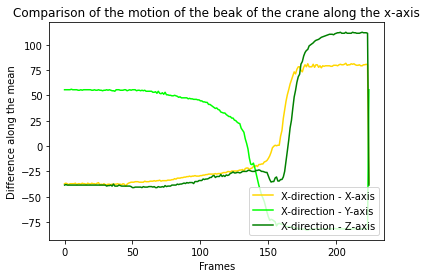

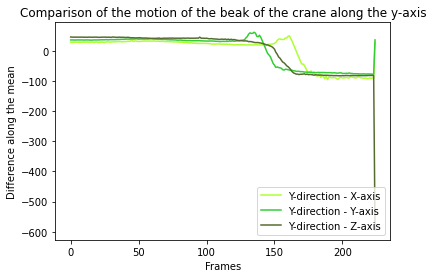

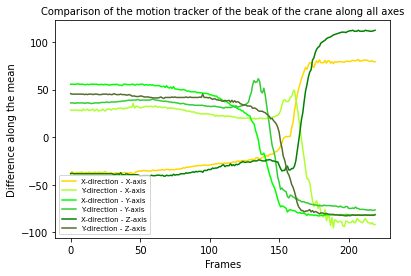

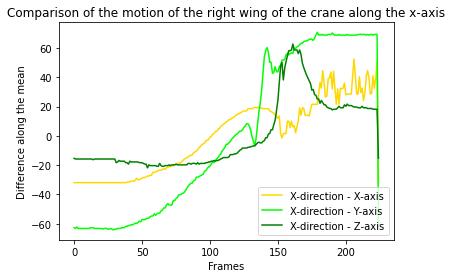

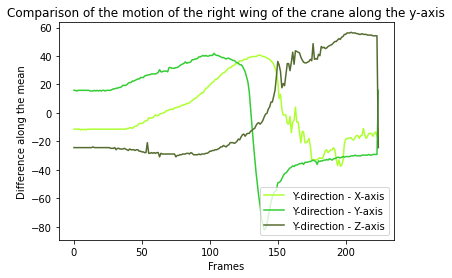

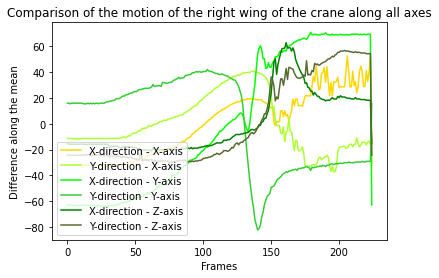

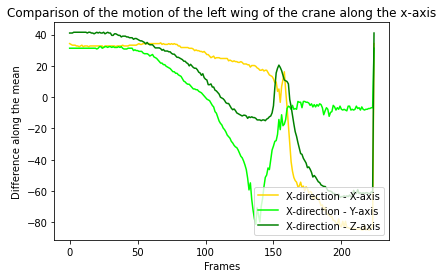

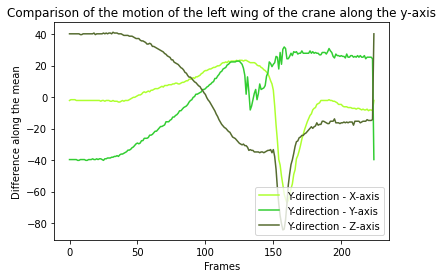

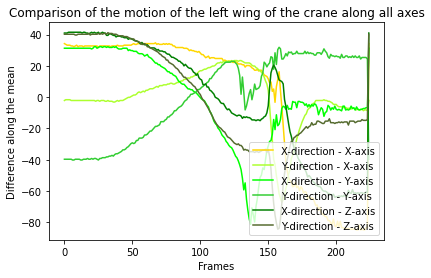

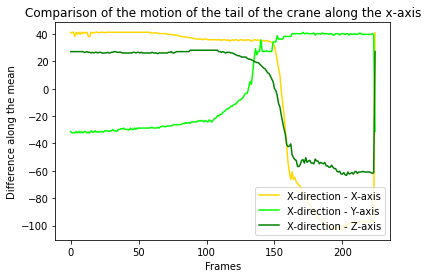

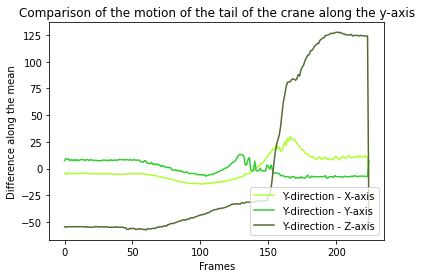

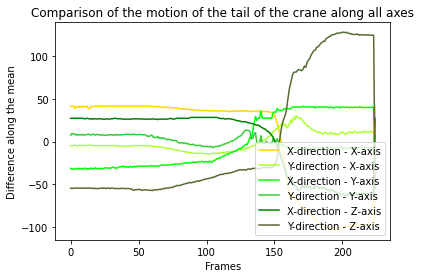

In [9]:
lib.plot(mat_beak[0,:], c = "gold", label = "X-direction - X-axis")
lib.plot(mat_beak[2,:], c = "lime", label = "X-direction - Y-axis")
lib.plot(mat_beak[4,:], c = "green", label = "X-direction - Z-axis")
lib.xlabel("Frames")
lib.ylabel("Difference along the mean")
lib.title("Comparison of the motion of the beak of the crane along the x-axis")
lib.legend(loc = "lower right", prop = {"size":10})
lib.savefig("beak_means_x.png")
lib.show()

lib.plot(mat_beak[1,:], c = "greenyellow", label = "Y-direction - X-axis")
lib.plot(mat_beak[3,:], c = "limegreen", label = "Y-direction - Y-axis")
lib.plot(mat_beak[5,:], c = "darkolivegreen", label = "Y-direction - Z-axis")
lib.xlabel("Frames")
lib.ylabel("Difference along the mean")
lib.title("Comparison of the motion of the beak of the crane along the y-axis")
lib.legend(loc = "lower right", prop = {"size":10})
lib.savefig("beak_means_y.png")
lib.show()

lib.plot(mat_beak[0,0:220], c = "gold", label = "X-direction - X-axis")
lib.plot(mat_beak[1,0:220], c = "greenyellow", label = "Y-direction - X-axis")
lib.plot(mat_beak[2,0:220], c = "lime", label = "X-direction - Y-axis")
lib.plot(mat_beak[3,0:220], c = "limegreen", label = "Y-direction - Y-axis")
lib.plot(mat_beak[4,0:220], c = "green", label = "X-direction - Z-axis")
lib.plot(mat_beak[5,0:220], c = "darkolivegreen", label = "Y-direction - Z-axis")
lib.xlabel("Frames")
lib.ylabel("Difference along the mean")
lib.title("Comparison of the motion tracker of the beak of the crane along all axes", fontsize = 10)
lib.legend(loc = "lower left", prop = {"size":7})
lib.savefig("beak_means.png")
lib.show()

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

lib.plot(mat_rw[0,:], c = "gold", label = "X-direction - X-axis")
lib.plot(mat_rw[2,:], c = "lime", label = "X-direction - Y-axis")
lib.plot(mat_rw[4,:], c = "green", label = "X-direction - Z-axis")
lib.xlabel("Frames")
lib.ylabel("Difference along the mean")
lib.title("Comparison of the motion of the right wing of the crane along the x-axis")
lib.legend(loc = "lower right", prop = {"size":10})
lib.savefig("rw_means_x.png")
lib.show()

lib.plot(mat_rw[1,:], c = "greenyellow", label = "Y-direction - X-axis")
lib.plot(mat_rw[3,:], c = "limegreen", label = "Y-direction - Y-axis")
lib.plot(mat_rw[5,:], c = "darkolivegreen", label = "Y-direction - Z-axis")
lib.xlabel("Frames")
lib.ylabel("Difference along the mean")
lib.title("Comparison of the motion of the right wing of the crane along the y-axis")
lib.legend(loc = "lower right", prop = {"size":10})
lib.savefig("rw_means_y.png")
lib.show()

lib.plot(mat_rw[0,:], c = "gold", label = "X-direction - X-axis")
lib.plot(mat_rw[1,:], c = "greenyellow", label = "Y-direction - X-axis")
lib.plot(mat_rw[2,:], c = "lime", label = "X-direction - Y-axis")
lib.plot(mat_rw[3,:], c = "limegreen", label = "Y-direction - Y-axis")
lib.plot(mat_rw[4,:], c = "green", label = "X-direction - Z-axis")
lib.plot(mat_rw[5,:], c = "darkolivegreen", label = "Y-direction - Z-axis")
lib.xlabel("Frames")
lib.ylabel("Difference along the mean")
lib.title("Comparison of the motion of the right wing of the crane along all axes")
lib.legend(loc = "lower left", prop = {"size":10})
lib.savefig("rw_means.png")
lib.show()

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

lib.plot(mat_lw[0,:], c = "gold", label = "X-direction - X-axis")
lib.plot(mat_lw[2,:], c = "lime", label = "X-direction - Y-axis")
lib.plot(mat_lw[4,:], c = "green", label = "X-direction - Z-axis")
lib.xlabel("Frames")
lib.ylabel("Difference along the mean")
lib.title("Comparison of the motion of the left wing of the crane along the x-axis")
lib.legend(loc = "lower right", prop = {"size":10})
lib.savefig("lw_means_x.png")
lib.show()

lib.plot(mat_lw[1,:], c = "greenyellow", label = "Y-direction - X-axis")
lib.plot(mat_lw[3,:], c = "limegreen", label = "Y-direction - Y-axis")
lib.plot(mat_lw[5,:], c = "darkolivegreen", label = "Y-direction - Z-axis")
lib.xlabel("Frames")
lib.ylabel("Difference along the mean")
lib.title("Comparison of the motion of the left wing of the crane along the y-axis")
lib.legend(loc = "lower right", prop = {"size":10})
lib.savefig("lw_means_y.png")
lib.show()

lib.plot(mat_lw[0,:], c = "gold", label = "X-direction - X-axis")
lib.plot(mat_lw[1,:], c = "greenyellow", label = "Y-direction - X-axis")
lib.plot(mat_lw[2,:], c = "lime", label = "X-direction - Y-axis")
lib.plot(mat_lw[3,:], c = "limegreen", label = "Y-direction - Y-axis")
lib.plot(mat_lw[4,:], c = "green", label = "X-direction - Z-axis")
lib.plot(mat_lw[5,:], c = "darkolivegreen", label = "Y-direction - Z-axis")
lib.xlabel("Frames")
lib.ylabel("Difference along the mean")
lib.title("Comparison of the motion of the left wing of the crane along all axes")
lib.legend(loc = "lower right", prop = {"size":10})
lib.savefig("lw_means.png")
lib.show()

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

lib.plot(mat_tail[0,:], c = "gold", label = "X-direction - X-axis")
lib.plot(mat_tail[2,:], c = "lime", label = "X-direction - Y-axis")
lib.plot(mat_tail[4,:], c = "green", label = "X-direction - Z-axis")
lib.xlabel("Frames")
lib.ylabel("Difference along the mean")
lib.title("Comparison of the motion of the tail of the crane along the x-axis")
lib.legend(loc = "lower right", prop = {"size":10})
lib.savefig("tail_means_x.png")
lib.show()

lib.plot(mat_tail[1,:], c = "greenyellow", label = "Y-direction - X-axis")
lib.plot(mat_tail[3,:], c = "limegreen", label = "Y-direction - Y-axis")
lib.plot(mat_tail[5,:], c = "darkolivegreen", label = "Y-direction - Z-axis")
lib.xlabel("Frames")
lib.ylabel("Difference along the mean")
lib.title("Comparison of the motion of the tail of the crane along the y-axis")
lib.legend(loc = "lower right", prop = {"size":10})
lib.savefig("tail_means_y.png")
lib.show()

lib.plot(mat_tail[0,:], c = "gold", label = "X-direction - X-axis")
lib.plot(mat_tail[1,:], c = "greenyellow", label = "Y-direction - X-axis")
lib.plot(mat_tail[2,:], c = "lime", label = "X-direction - Y-axis")
lib.plot(mat_tail[3,:], c = "limegreen", label = "Y-direction - Y-axis")
lib.plot(mat_tail[4,:], c = "green", label = "X-direction - Z-axis")
lib.plot(mat_tail[5,:], c = "darkolivegreen", label = "Y-direction - Z-axis")
lib.xlabel("Frames")
lib.ylabel("Difference along the mean")
lib.title("Comparison of the motion of the tail of the crane along all axes")
lib.legend(loc = "lower right", prop = {"size":10})
lib.savefig("tail_means.png")
lib.show()

In [10]:
## RUNNING PCA: STEP 1 - COVARIANCE MATRIX
# This allows to determine the dominant spatial directions of motion (how one moves around in the projected plane).

In [11]:
## DIAGONALIZING THROUGH SVD: REMOVING REDUNDANCIES

Ub, Sb, VTb = np.linalg.svd(mat_beak)
UTb = np.transpose(Ub)

Ur, Sr, VTr = np.linalg.svd(mat_rw)
UTr = np.transpose(Ur)

Ul, Sl, VTl = np.linalg.svd(mat_lw)
UTl = np.transpose(Ul)

Ut, St, VTt = np.linalg.svd(mat_tail)
UTt = np.transpose(Ut)

In [12]:
## RUNNING PCA: STEP 2 - COVARIANCE MATRIX WITHOUT TIME

Yb = np.matmul(UTb, mat_beak) # These allow for a change in basis, effectively removing time.
covmatYb = np.cov(Yb) # Determining the dominant spatial directions of motion without time.

print(covmatYb.shape)
print(covmatYb) # It is a diagonal matrix.

Yr = np.matmul(UTr, mat_rw) # These allow for a change in basis, effectively removing time.
covmatYr = np.cov(Yr) # Determining the dominant spatial directions of motion without time.

print(covmatYr.shape)
print(covmatYr) # It is a diagonal matrix.

Yl = np.matmul(UTl, mat_lw) # These allow for a change in basis, effectively removing time.
covmatYl = np.cov(Yl) # Determining the dominant spatial directions of motion without time.

print(covmatYl.shape)
print(covmatYl) # It is a diagonal matrix.

Yt = np.matmul(UTt, mat_tail) # These allow for a change in basis, effectively removing time.
covmatYt = np.cov(Yt) # Determining the dominant spatial directions of motion without time.

print(covmatYt.shape)
print(covmatYt) # It is a diagonal matrix.

(6, 6)
[[ 1.62051435e+04  1.38048303e-12 -9.74458609e-13 -2.95585778e-12
   2.89190893e-12  1.21908832e-12]
 [ 1.38048303e-12  1.59256060e+03  3.59331612e-13 -1.37033242e-13
  -2.94875235e-13  3.46389584e-14]
 [-9.74458609e-13  3.59331612e-13  1.02547824e+03 -3.65421978e-13
  -2.36255460e-13 -4.11734139e-14]
 [-2.95585778e-12 -1.37033242e-13 -3.65421978e-13  1.40534536e+02
  -1.39570895e-15  3.19427025e-14]
 [ 2.89190893e-12 -2.94875235e-13 -2.36255460e-13 -1.39570895e-15
   4.13617315e+01  4.12368552e-16]
 [ 1.21908832e-12  3.46389584e-14 -4.11734139e-14  3.19427025e-14
   4.12368552e-16  2.83656571e+00]]
(6, 6)
[[ 5.66861460e+03  9.74458609e-13  3.24819536e-13 -4.30385886e-13
   6.69940294e-14 -1.66774531e-12]
 [ 9.74458609e-13  5.94174326e+02 -1.62409768e-14 -1.17747082e-13
  -1.19777204e-13 -1.68246369e-13]
 [ 3.24819536e-13 -1.62409768e-14  3.81616376e+02  1.19777204e-13
  -1.62409768e-14  8.12048841e-15]
 [-4.30385886e-13 -1.17747082e-13  1.19777204e-13  1.26720300e+02
  -5.17681

(6,)
[1905.2433313   597.27177547  479.27771366  177.42529708   96.25501468
   25.20695775]


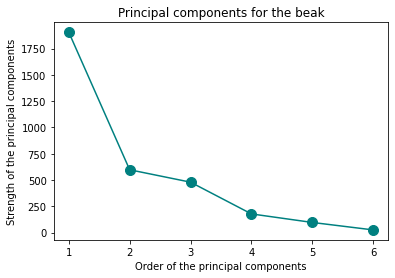

(6,)
[1126.84056961  364.82194155  292.37316589  168.4795159    78.98229949
   57.2057723 ]


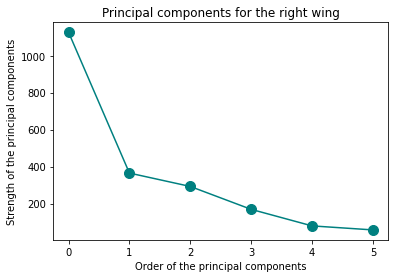

(6,)
[1008.56294506  512.95776181  309.31103471  143.26487973   44.82852179
   30.42045952]


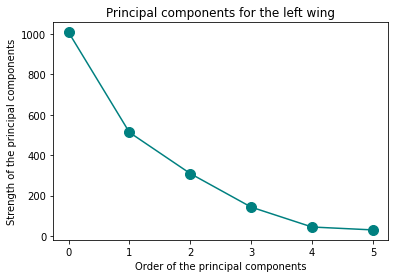

(6,)
[1561.11541556  232.6146023   109.44108324   63.09742291   32.79091046
   20.14155841]


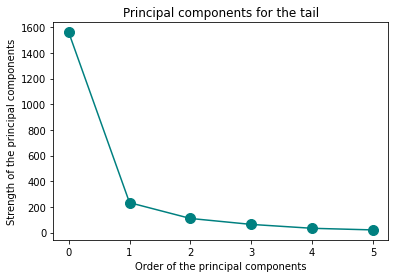

In [13]:
print(Sb.shape)
print(Sb)

t = (1,2,3,4,5,6)

lib.plot(t, Sb, marker = 'o', markersize = 10, c = 'teal')
lib.xlabel('Order of the principal components')
lib.ylabel('Strength of the principal components')
lib.title('Principal components for the beak')
lib.savefig("Principal_Components_beak.png")
lib.show()

print(Sr.shape)
print(Sr)

lib.plot(Sr, marker = 'o', markersize = 10, c = 'teal')
lib.xlabel('Order of the principal components')
lib.ylabel('Strength of the principal components')
lib.title('Principal components for the right wing')
lib.savefig("Principal_Components_rw.png")
lib.show()

print(Sl.shape)
print(Sl)

lib.plot(Sl, marker = 'o', markersize = 10, c = 'teal')
lib.xlabel('Order of the principal components')
lib.ylabel('Strength of the principal components')
lib.title('Principal components for the left wing')
lib.savefig("Principal_Components_lw.png")
lib.show()

print(St.shape)
print(St)

lib.plot(St, marker = 'o', markersize = 10, c = 'teal')
lib.xlabel('Order of the principal components')
lib.ylabel('Strength of the principal components')
lib.title('Principal components for the tail')
lib.savefig("Principal_Components_tail.png")
lib.show()

# The principal components in this scenario determine the directions in which the variation occurs the most. 

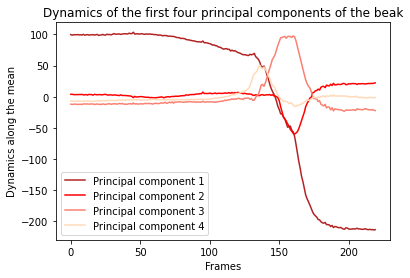

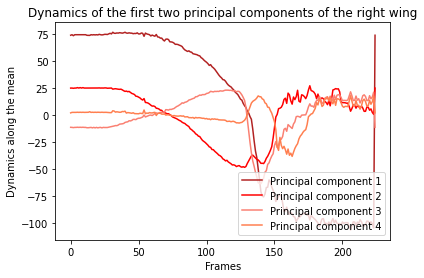

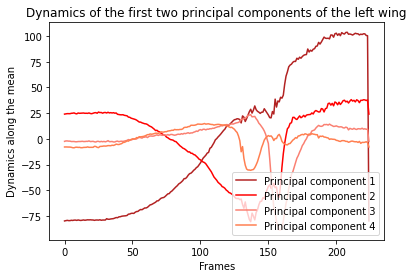

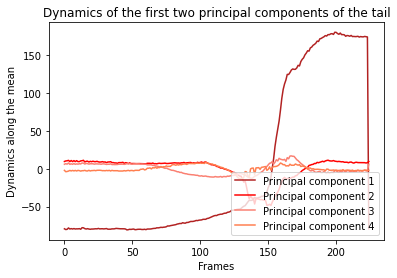

In [14]:
lib.plot(Sb[0]*VTb[0,0:220], c = 'firebrick', label = 'Principal component 1')
lib.plot(Sb[1]*VTb[1,0:220], c = 'red', label = 'Principal component 2')
lib.plot(Sb[2]*VTb[2,0:220], c = 'salmon', label = 'Principal component 3')
lib.plot(Sb[3]*VTb[3,0:220], c = 'peachpuff', label = 'Principal component 4')
lib.xlabel('Frames')
lib.ylabel('Dynamics along the mean')
lib.title('Dynamics of the first four principal components of the beak')
lib.legend(loc = 'lower left', prop = {'size':10})
lib.savefig("PCA_beak.png")
lib.show()

lib.plot(Sr[0]*VTr[0,:], c = 'firebrick', label = 'Principal component 1')
lib.plot(Sr[1]*VTr[1,:], c = 'red', label = 'Principal component 2')
lib.plot(Sr[2]*VTr[2,:], c = 'salmon', label = 'Principal component 3')
lib.plot(Sr[3]*VTr[3,:], c = 'coral', label = 'Principal component 4')
lib.xlabel('Frames')
lib.ylabel('Dynamics along the mean')
lib.title('Dynamics of the first two principal components of the right wing')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("PCA_rw.png")
lib.show()

lib.plot(Sl[0]*VTl[0,:], c = 'firebrick', label = 'Principal component 1')
lib.plot(Sl[1]*VTl[1,:], c = 'red', label = 'Principal component 2')
lib.plot(Sl[2]*VTl[2,:], c = 'salmon', label = 'Principal component 3')
lib.plot(Sl[3]*VTl[3,:], c = 'coral', label = 'Principal component 4')
lib.xlabel('Frames')
lib.ylabel('Dynamics along the mean')
lib.title('Dynamics of the first two principal components of the left wing')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("PCA_lw.png")
lib.show()

lib.plot(St[0]*VTt[0,:], c = 'firebrick', label = 'Principal component 1')
lib.plot(St[1]*VTt[1,:], c = 'red', label = 'Principal component 2')
lib.plot(St[2]*VTt[2,:], c = 'salmon', label = 'Principal component 3')
lib.plot(St[3]*VTt[3,:], c = 'coral', label = 'Principal component 4')
lib.xlabel('Frames')
lib.ylabel('Dynamics along the mean')
lib.title('Dynamics of the first two principal components of the tail')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("PCA_tail.png")
lib.show()

In [15]:
! pip install pysindy
import pysindy as py

In [16]:
model = py.SINDy()
print(model)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=PolynomialLibrary(), optimizer=STLSQ())


In [258]:
mat_beak_reduced = np.transpose(Ub[:,0:1])@mat_beak

print(mat_beak_reduced.shape)
print(mat_beak_reduced)

mat_beak_reducedT = np.transpose(mat_beak_reduced)
print(mat_beak_reducedT.shape)
print(mat_beak_reducedT)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

mat_rw_reduced = np.transpose(Ur[:,0:4])@mat_rw

print(mat_rw_reduced.shape)
print(mat_rw_reduced)

mat_rw_reducedT = np.transpose(mat_rw_reduced)
print(mat_rw_reducedT.shape)
print(mat_rw_reducedT)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

mat_lw_reduced = np.transpose(Ul[:,0:4])@mat_lw

print(mat_lw_reduced.shape)
print(mat_lw_reduced)

mat_lw_reducedT = np.transpose(mat_lw_reduced)
print(mat_lw_reducedT.shape)
print(mat_lw_reducedT)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

mat_tail_reduced = np.transpose(Ut[:,0:4])@mat_tail

print(mat_tail_reduced.shape)
print(mat_tail_reduced)

mat_tail_reducedT = np.transpose(mat_tail_reduced)
print(mat_tail_reducedT.shape)
print(mat_tail_reducedT)

(1, 225)
[[ 9.97993806e+01  9.89919393e+01  9.95747186e+01  9.97581879e+01
   9.95747186e+01  9.97962641e+01  9.94012347e+01  9.95747186e+01
   9.90412421e+01  1.00294704e+02  9.89389630e+01  9.93531731e+01
   9.98835331e+01  9.89931805e+01  9.93851705e+01  9.93851705e+01
   9.98804936e+01  9.90412421e+01  9.95747186e+01  1.00108195e+02
   9.85950346e+01  9.89550272e+01  9.93661208e+01  1.00076198e+02
   9.91827287e+01  9.90442815e+01  1.00452255e+02  9.98515358e+01
   1.00041161e+02  9.95076074e+01  1.00227593e+02  1.01517519e+02
   1.00488533e+02  1.00485416e+02  1.00764109e+02  1.00801628e+02
   1.00135143e+02  1.00769631e+02  1.01087299e+02  1.01247758e+02
   1.00953580e+02  1.00954821e+02  1.02125294e+02  1.01338067e+02
   1.01486345e+02  1.03620251e+02  1.00696286e+02  1.01014088e+02
   1.01238673e+02  1.00706437e+02  1.01045638e+02  1.01235186e+02
   1.00774713e+02  1.00280444e+02  1.00675473e+02  1.00861982e+02
   1.00466952e+02  1.00860106e+02  1.00382536e+02  1.00245253e+02
 

In [259]:
X1b = mat_beak_reducedT[:,0]
#X2b = mat_beak_reducedT[:,1]
#X3b = mat_beak_reducedT[:,2]
#X4b = mat_beak_reducedT[:,3]

print(X1b.shape)
print(X2b.shape)

X1r = mat_rw_reducedT[:,0]
X2r = mat_rw_reducedT[:,1]
X3r = mat_rw_reducedT[:,2]
X4r = mat_rw_reducedT[:,3]

X1l = mat_lw_reducedT[:,0]
X2l = mat_lw_reducedT[:,1]
X3l = mat_lw_reducedT[:,2]
X4l = mat_lw_reducedT[:,3]

X1t = mat_tail_reducedT[:,0]
X2t = mat_tail_reducedT[:,1]
X3t = mat_tail_reducedT[:,2]
X4t = mat_tail_reducedT[:,3]

(225,)
(225, 1)


In [260]:
featurenamesb = ['X1b']

featurenamesr = ['X1r', 'X2r', 'X3r', 'X4r']

featurenamesl = ['X1l', 'X2l', 'X3l', 'X4l']

featurenamest = ['X1t', 'X2t', 'X3t', 'X4t']

optim = py.STLSQ(threshold = 0.3)
t = np.arange(0,7,7/225)

In [261]:
modelb = py.SINDy(feature_names = featurenamesb, optimizer = optim)

# The models should have some kind of symmetry! 

In [262]:
modelr = py.SINDy(feature_names = featurenamesr, optimizer = optim)

# The models should have some kind of symmetry! 

In [263]:
modell = py.SINDy(feature_names = featurenamesl, optimizer = optim)

# The models should have some kind of symmetry! 

In [264]:
modelt = py.SINDy(feature_names = featurenamest, optimizer = optim)

# The models should have some kind of symmetry! 

In [265]:
modelb.fit(mat_beak_reducedT, t) # Frames by the duration of the video.

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['X1b'],
      optimizer=STLSQ(threshold=0.3))

In [266]:
modelr.fit(mat_rw_reducedT, t) # Frames by the duration of the video.

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(),
      feature_names=['X1r', 'X2r', 'X3r', 'X4r'],
      optimizer=STLSQ(threshold=0.3))

In [267]:
modell.fit(mat_lw_reducedT, t) # Frames by the duration of the video.

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(),
      feature_names=['X1l', 'X2l', 'X3l', 'X4l'],
      optimizer=STLSQ(threshold=0.3))

In [268]:
modelt.fit(mat_tail_reducedT, t) # Frames by the duration of the video.

C:\Users\pinar\anaconda3\envs\MATH494\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.3) and eliminated all coefficients
  warnings.warn(
C:\Users\pinar\anaconda3\envs\MATH494\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.3) and eliminated all coefficients
  warnings.warn(


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(),
      feature_names=['X1t', 'X2t', 'X3t', 'X4t'],
      optimizer=STLSQ(threshold=0.3))

In [257]:
print(modelb)
modelb.print()

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['X1b'],
      optimizer=STLSQ(threshold=0.3))


IndexError: list index out of range

In [166]:
print(modelr)
modelr.print()

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(),
      feature_names=['X1r', 'X2r', 'X3r', 'X4r'],
      optimizer=STLSQ(threshold=0.3))
(X1r)' = 101.733 1 + -36.031 X2r + 32.914 X4r + -0.364 X1r X3r + -0.818 X2r^2 + -0.549 X2r X3r + 1.172 X2r X4r + 0.901 X3r^2 + -0.740 X3r X4r + 0.614 X4r^2
(X2r)' = 2.515 X3r + 3.733 X4r
(X3r)' = 1.415 1 + -0.494 X2r + -1.035 X4r
(X4r)' = 0.000


In [167]:
print(modell)
modell.print()

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(),
      feature_names=['X1l', 'X2l', 'X3l', 'X4l'],
      optimizer=STLSQ(threshold=0.3))
(X1l)' = 101.733 1 + -36.031 X2l + 32.914 X4l + -0.364 X1l X3l + -0.818 X2l^2 + -0.549 X2l X3l + 1.172 X2l X4l + 0.901 X3l^2 + -0.740 X3l X4l + 0.614 X4l^2
(X2l)' = 2.515 X3l + 3.733 X4l
(X3l)' = 1.415 1 + -0.494 X2l + -1.035 X4l
(X4l)' = 0.000


In [168]:
print(modelt)
modelt.print()

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(),
      feature_names=['X1t', 'X2t', 'X3t', 'X4t'],
      optimizer=STLSQ(threshold=0.3))
(X1t)' = 101.733 1 + -36.031 X2t + 32.914 X4t + -0.364 X1t X3t + -0.818 X2t^2 + -0.549 X2t X3t + 1.172 X2t X4t + 0.901 X3t^2 + -0.740 X3t X4t + 0.614 X4t^2
(X2t)' = 2.515 X3t + 3.733 X4t
(X3t)' = 1.415 1 + -0.494 X2t + -1.035 X4t
(X4t)' = 0.000


In [240]:
from scipy.integrate import odeint

X = [X1b, X2b]

def functionb(X, t):
    a=101.733
    b=-36.031
    c=32.914
    d=2.515
    e=3.733

    dX1bdt = a + b*X2b + c*X1b*X2b
    dx2bdt = d*X1b**2 + e*X1b*X2b
    
    return dX1bdt

def functionr(X1r, X2r, X3r, X4r, t):
    a=-36.281
    b=0.266
    c=-5.971
    d=0.269

    dxdt = a + b*X1r + c*Y1r
    dydt = d
    dzdt = [dxdt,dydt]

    return dzdt

def functionl(X1l, X2l, X3l, X4l, t):
    a=-36.281
    b=0.266
    c=-5.971
    d=0.269

    dxdt = a + b*X1l + c*Y1l
    dydt = d
    dzdt = [dxdt,dydt]

    return dzdt

def functiont(X1t, X2t, X3t, X4t, t):
    a=-36.281
    b=0.266
    c=-5.971
    d=0.269

    dxdt = a + b*X1t + c*Y1t
    dydt = d
    dzdt = [dxdt,dydt]

    return dzdt

In [241]:
## INITIAL CONDITIONS:

z0b = [mat_beak_reducedT[0,0], mat_beak_reducedT[0,1]]

#X1b = np.reshape(X1b, (225,1))
#X2b = np.reshape(X2b, (225,1))
print(z0b)

[99.79938064537194, 3.9473368309158503]


In [243]:
# Solving the ODE:

t = np.arange(0,7,7/225)
print(t)

zb = odeint(functionb, z0b, t)

lib.plot(t,zb[:,0], c = 'cornflowerblue')
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Approximation of the dynamics of the first principal components of the beak')
lib.savefig("SINDy_beak.png")
lib.show()

[0.         0.03111111 0.06222222 0.09333333 0.12444444 0.15555556
 0.18666667 0.21777778 0.24888889 0.28       0.31111111 0.34222222
 0.37333333 0.40444444 0.43555556 0.46666667 0.49777778 0.52888889
 0.56       0.59111111 0.62222222 0.65333333 0.68444444 0.71555556
 0.74666667 0.77777778 0.80888889 0.84       0.87111111 0.90222222
 0.93333333 0.96444444 0.99555556 1.02666667 1.05777778 1.08888889
 1.12       1.15111111 1.18222222 1.21333333 1.24444444 1.27555556
 1.30666667 1.33777778 1.36888889 1.4        1.43111111 1.46222222
 1.49333333 1.52444444 1.55555556 1.58666667 1.61777778 1.64888889
 1.68       1.71111111 1.74222222 1.77333333 1.80444444 1.83555556
 1.86666667 1.89777778 1.92888889 1.96       1.99111111 2.02222222
 2.05333333 2.08444444 2.11555556 2.14666667 2.17777778 2.20888889
 2.24       2.27111111 2.30222222 2.33333333 2.36444444 2.39555556
 2.42666667 2.45777778 2.48888889 2.52       2.55111111 2.58222222
 2.61333333 2.64444444 2.67555556 2.70666667 2.73777778 2.7688

RuntimeError: The array return by func must be one-dimensional, but got ndim=2.

In [244]:
# Solving the ODE:
zb = odeint(functionb, z0b, t)

lib.plot(t,zb[:,0], c = 'cornflowerblue', label = 'Principal component 1')
lib.plot(t,zb[:,1], c = 'coral', label = 'Principal component 2')
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Approximation of the dynamics of the two first principal components of the beak')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("SINDy_beak.png")
lib.show()

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

z0r = [mat_rw_reducedT[0,0], mat_rw_reducedT[0,1]]

# Solving the ODE:
zr = odeint(functionr, z0r, t)

lib.plot(t,zr[:,0], c = 'cornflowerblue', label = 'Principal component 1')
lib.plot(t,zr[:,1], c = 'coral', label = 'Principal component 2')
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Approximation of the dynamics of the two first principal components of the right wing')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("SINDy_rw.png")
lib.show()

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

z0l = [mat_lw_reducedT[0,0], mat_lw_reducedT[0,1]]

# Solving the ODE:
zl = odeint(functionl, z0l, t)

lib.plot(t,zl[:,0], c = 'cornflowerblue', label = 'Principal component 1')
lib.plot(t,zl[:,1], c = 'coral', label = 'Principal component 2')
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Approximation of the dynamics of the two first principal components of the left wing')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("SINDy_lw.png")
lib.show()

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

z0t = [mat_tail_reducedT[0,0], mat_tail_reducedT[0,1]]

# Solving the ODE:
zt = odeint(functiont, z0t, t)

lib.plot(t,zt[:,0], c = 'cornflowerblue', label = 'Principal component 1')
lib.plot(t,zt[:,1], c = 'coral', label = 'Principal component 2')
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Approximation of the dynamics of the two first principal components of the tail')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("SINDy_tail.png")
lib.show()

RuntimeError: The array return by func must be one-dimensional, but got ndim=2.

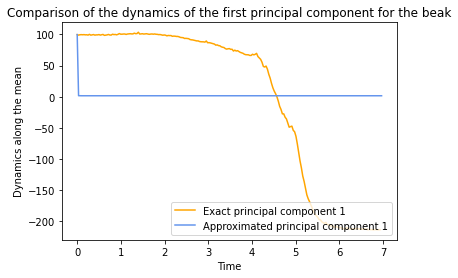

ValueError: x and y must have same first dimension, but have shapes (224,) and (225,)

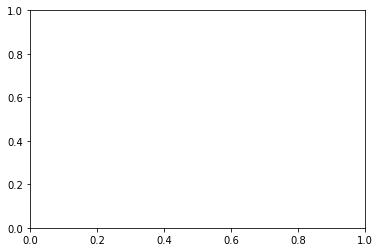

In [245]:
lib.plot(t[0:224], Sb[0]*VTb[0,0:224], c = 'orange', label = 'Exact principal component 1') 
lib.plot(t, zb[:,0], c = 'cornflowerblue', label = 'Approximated principal component 1') 
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Comparison of the dynamics of the first principal component for the beak')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("Compare1_beak.png")
lib.show()

# MAY NEED TO NORMALIZE ON 250...

lib.plot(t[0:224], Sr[0]*VTr[0,:], c = 'orange', label = 'Exact principal component 1') 
lib.plot(t, zr[:,0], c = 'cornflowerblue', label = 'Approximated principal component 1') 
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Comparison of the dynamics of the first principal component for the right wing')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("Compare1_rw.png")
lib.show()

lib.plot(t[0:224], Sl[0]*VTl[0,:], c = 'orange', label = 'Exact principal component 1') 
lib.plot(t, zl[:,0], c = 'cornflowerblue', label = 'Approximated principal component 1') 
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Comparison of the dynamics of the first principal component for the left wing')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("Compare1_lw.png")
lib.show()

lib.plot(t[0:224], St[0]*VTt[0,:], c = 'orange', label = 'Exact principal component 1') 
lib.plot(t, zt[:,0], c = 'cornflowerblue', label = 'Approximated principal component 1') 
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Comparison of the dynamics of the first principal component for the tail')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("Compare1_tail.png")
lib.show()

In [ ]:
lib.plot(t[0:224], Sb[1]*VTb[1,:], c = 'coral', label = 'Exact principal component 2')
lib.plot(t, zb[:,1], c = 'teal', label = 'Approximated principal component 2')
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Comparison of the dynamics of the second principal component for the beak')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("Compare2_beak.png")
lib.show() 

lib.plot(t[0:224], Sr[1]*VTr[1,:], c = 'coral', label = 'Exact principal component 2')
lib.plot(t, zr[:,1], c = 'teal', label = 'Approximated principal component 2')
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Comparison of the dynamics of the second principal component for the right wing')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("Compare2_rw.png")
lib.show() 

lib.plot(t[0:224], Sl[1]*VTl[1,:], c = 'coral', label = 'Exact principal component 2')
lib.plot(t, zl[:,1], c = 'teal', label = 'Approximated principal component 2')
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Comparison of the dynamics of the second principal component for the left wing')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("Compare2_lw.png")
lib.show() 

lib.plot(t[0:224], St[1]*VTt[1,:], c = 'coral', label = 'Exact principal component 2')
lib.plot(t, zt[:,1], c = 'teal', label = 'Approximated principal component 2')
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Comparison of the dynamics of the second principal component for the tail')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("Compare2_tail.png")
lib.show() 

NameError: name 'zt' is not defined

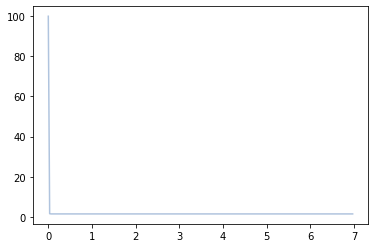

In [246]:
lib.plot(t,zb[:,0], c = 'lightsteelblue', label = 'Principal component 1 of the beak')
lib.plot(t,zt[:,0], c = 'cornflowerblue', label = 'Principal component 1 of the tail')
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Comparison of the SINDy models for the first principal component of the beak and tail')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("SINDy1_bt.png")
lib.show()

lib.plot(t,zb[:,1], c = 'bisque', label = 'Principal component 2 of the beak')
lib.plot(t,zt[:,1], c = 'coral', label = 'Principal component 2 of the tail')
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Comparison of the SINDy models for the second principal component of the beak and tail')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("SINDy2_bt.png")
lib.show()

# Here, there should be some kind of symmetry, only changing at the very end when the beak folds over.

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

lib.plot(t,zr[:,0], c = 'lightsteelblue', label = 'Principal component 1 of the right wing')
lib.plot(t,zl[:,0], c = 'cornflowerblue', label = 'Principal component 1 of the left wing')
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Comparison of the SINDy models for the first principal component of the right and left wings')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("SINDy1_rlw.png")
lib.show()

lib.plot(t,zr[:,1], c = 'bisque', label = 'Principal component 2 of the right wing')
lib.plot(t,zl[:,1], c = 'coral', label = 'Principal component 2 of the left wing')
lib.xlabel('Time')
lib.ylabel('Dynamics along the mean')
lib.title('Comparison of the SINDy models for the second principal component of the right and left wings')
lib.legend(loc = 'lower right', prop = {'size':10})
lib.savefig("SINDy2_rlw.png")
lib.show()

# Here, they should be perfectly symmetrical.

In [247]:
## FUTURE DIRECTION:

# Run another analysis where we compare motion along the axes rather than the corners.